### Relationships Between Variables
Two variables are related if knowing one (independent variable; x) gives you information about the other (dependent variable; y). For example, height and weight are related; taller people tend to be heavier.

#### Scatter Plots
A **scatter plot** is the simplest graph used to compare two variables.

Let's compare heights and weights of people in the CDC Demographic data:

In [1]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
from cycler import cycler

matplotlib.style.use("dark_background")
%matplotlib inline
rcParams["figure.figsize"] = (12, 6)
rcParams["axes.prop_cycle"] = cycler(color=["#4299E1", "#F56565", "#48BB78"])
rcParams["axes.facecolor"] = "#1A202C"
rcParams["axes.edgecolor"] = "#A0AEC0"
rcParams["axes.grid"] = True
rcParams["grid.color"] = "#A0AEC0"
rcParams["grid.alpha"] = 0.7
rcParams["axes.titlecolor"] = "#A0AEC0"
rcParams["axes.labelcolor"] = "#A0AEC0"
rcParams["xtick.color"] = "#A0AEC0"
rcParams["ytick.color"] = "#A0AEC0"

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns

df = pd.read_pickle("cdc_demographic_2008-clean.pkl")
df.head()

,Age,Gender,Weight_kg_1yr,finalwt,Weight_kg,Height_cm
0,82.0,F,76.363636,185.870345,70.91,157.0
1,65.0,F,72.727273,126.603027,72.73,163.0
2,48.0,F,NaN,181.063210,NaN,165.0
3,61.0,M,73.636364,517.926275,73.64,170.0
4,26.0,M,88.636364,1252.624630,88.64,185.0


In [46]:
heights = df["Height_cm"]
weights = df["Weight_kg"]

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

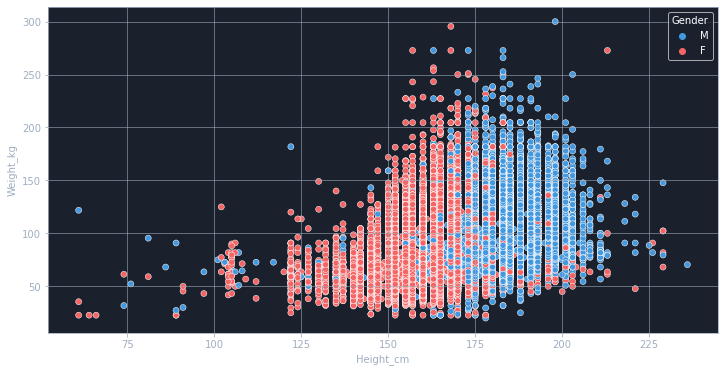

In [54]:
sns.scatterplot(x="Height_cm", y="Weight_kg", hue="Gender", hue_order=["M", "F"], data=df)

Since Seaborn *scatterplot* doesn't support jitter yet, we can also use *regplot* without fitting a linear regression model, adding jitter, and making it basically a scatter plot.

However, we can't use the `hue` parameter to separate the plot by **Gender**.

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

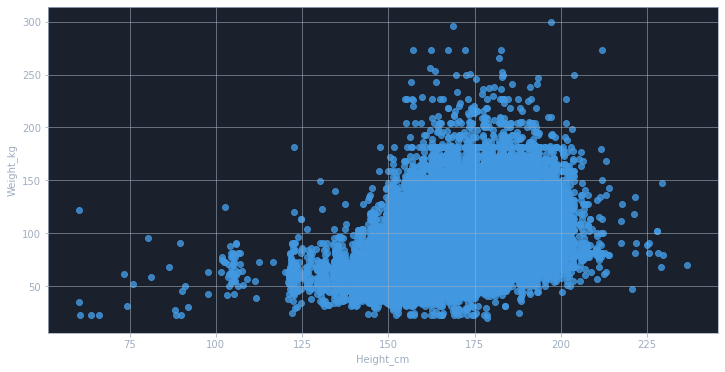

In [43]:
sns.regplot(x="Height_cm", y="Weight_kg", scatter=True, fit_reg=False, x_jitter=True, data=df)

We can also create our own `Jitter` function, and jitter each variable to reduce the visual effect of rounding.

However, jittering data should only be used for visualization and not for analysis, because it will introduce a lot of inaccuracies due to noise.

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

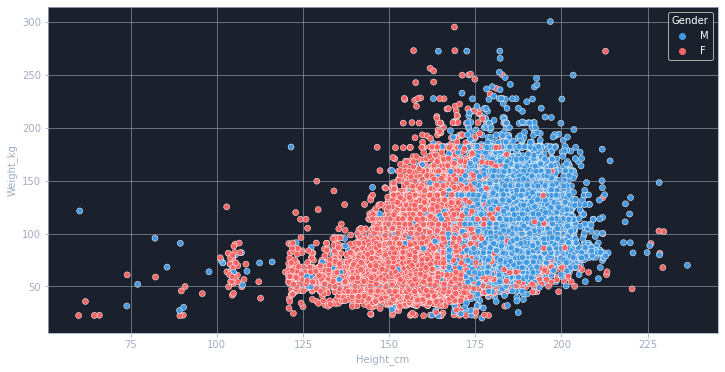

In [55]:
def Jitter(values, jitter=0.5):
    return np.random.uniform(-jitter, jitter, len(values)) + values

sns.scatterplot(x=Jitter(heights, 1.3), y=Jitter(weights), hue=df["Gender"], hue_order=["M", "F"])

Even with jittering, it's still quite hard to interpret this plot due to many overlapping points, which gives disproportionate emphasis to outliers, called **saturation**. We can use the `alpha` parameter to make the points a bit more transparent. We can also remove the edge line for each plot points.

<AxesSubplot:xlabel='Height_cm', ylabel='Weight_kg'>

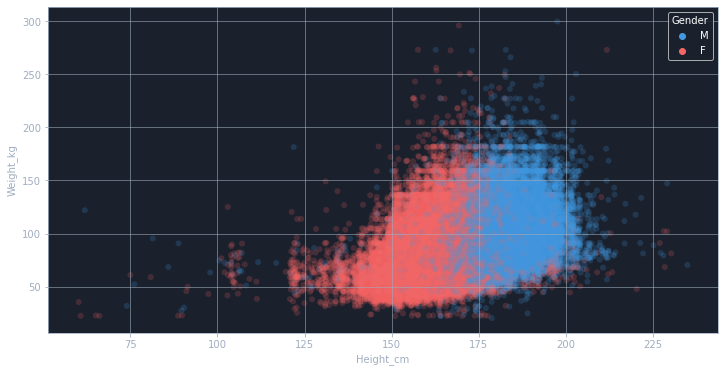

In [56]:
sns.scatterplot(x=Jitter(heights, 1.3), y=Jitter(weights), hue=df["Gender"], hue_order=["M", "F"], alpha=0.2, linewidth=0)

To handle larger datasets, we can also use a hexbin plot, using Seaborn's *jointplot* and setting its `kind` parameter to "hex". This plot will divide the graph into hexagonal bins and the darker the hexagon, the more points fall in that hexagon.

Hexbin plots show the shape of the relationship well. However, it makes outliers invisible.

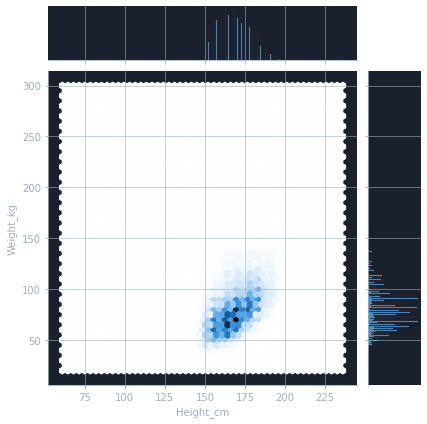

In [59]:
sns.jointplot(x="Height_cm", y="Weight_kg", kind="hex", data=df)

#### Characterizing Relationships
Another way to show the relationship of two variables is by binning one variable and plotting percentiles of the other.

In [168]:
df = df.dropna(subset=["Height_cm", "Weight_kg"])
bins = np.arange(135, 210, 5)

# Gives an index for each height which will determine which group it should go into
indices = np.digitize(df["Height_cm"], bins)

# Groups values based on the indices
groups = df.groupby(indices)

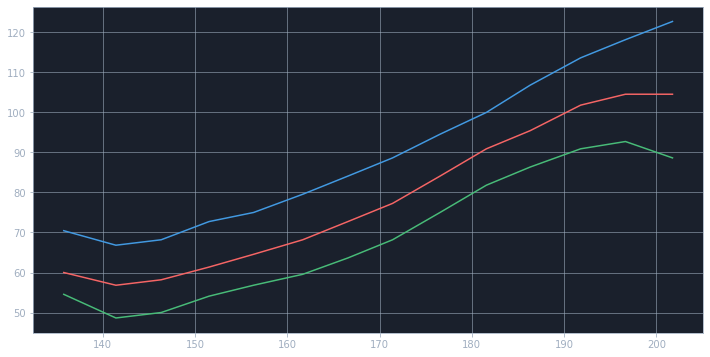

In [169]:
import bisect

def Percentile(sample, percentileRank):
    # First, create a dictionary with the key as the unique values, 
    # and the value as the amount of those unique values
    d = {}
    d.update(sample.value_counts().iteritems())
    
    # Now, we unwrap that dictionary (sorted by key) using zip
    xs, freqs = zip(*sorted(d.items()))
    
    # We make the xs (the unique values) as a numpy array
    # We make the ps the cumulative sum of the freqs (the amount of unique values)
    xs = np.asarray(xs)
    ps = np.cumsum(freqs)
    
    # This normalizes the cumulative sums to the range [0, 1]
    ps = ps / ps[-1]
    
    # Determine which value is associated with the given percentile rank
    index = bisect.bisect_left(ps, percentileRank)
    return xs[index]

heights = [group["Height_cm"].mean() for i, group in groups]

for percent in [75, 50, 25]:
    weights = [Percentile(group["Weight_kg"], percent / 100) for i, group in groups]
    # Array slicing here is needed if we want the same result as in the Think Stats chapter
    plt.plot(heights[1:15], weights[1:15])